### Juan David Orjuela - Sofía Álvarez López

In [1]:
%load_ext tensorboard

In [2]:
# ESAI
import os
import cv2
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

<h1 align = 'center'>Laboratorio 3: Machine Learning Techniques</h1>

## Problema 

Ante la situación actual de sanidad pública en el mundo a causa del COVID-19. La detección temprana de esta enfermedad en los pacientes, la automatización de procesos de diagnóstico y el apoyo a los diferentes expertos de esta enfermedad juega un papel muy importante para enfrentar una pandemia el cual ha registrado más de 230 millones de contagios, dejando sin vida a 4 millones de personas alrededor del mundo (OMS, 2021).

Sin embargo, todo este tiempo de cuarentena no solo ha servido para frenar la tasa de contagio del virus. También nos ha permitido recolectar diferentes radiografias de pacientes quienes han sufrido esta enfermedad, junto a otras enfermedades que pueden llegar a tener un una confusión con la enfermedad provocada por el virus. Por ello, es importante determinar con exactitud el tipo de enfermedad para poder recomendar el mejor tratamiento para el paciente.

Se han recolectado alrededor de 21 mil imágenes provenientes de diferentes paises del medio oriente como Catar, Pakistan y Malasia. Y, ante la reactivación económica que se quiere llevar a cabo, se teme una nueva ola de contagios, por lo que poder identificar estos casos dadas sus radiografías autmáticamente, sería de gran ayuda para los trabajadores de la Salud para determinar el tratamiento a los pacientes.

Para eso, le han pedido que construya un modelo capaz de recibir esas imágenes y determinar bajo que probabilidad puede pertenecer a cada una de las clases de las enfermedades proporcionadas. Y así mismo determinar cuál sería el diagnóstico de ese paciente. Como sugerencia, le han pedido construir una Red Neuronal Artificial (ANN) la cual permita realizar este proceso de manera automática y sin supervisión de los expertos en el tema.

Finalmente, Ante la urgencia del problema, le han pedido que utilicen las imágenes en escala de grises para poder realizar una carga y un almacenamiento de manera más óptima, y utilizar directamente como entrada esta imagen.

## Exploración y descripción de los datos
Lo primero que hacemos es explorar los datos de nuestro dataset. Notamos que este se compone de cuatro carpetas:

In [3]:
directorio = r'COVID-19_Radiography_Dataset'
print(os.listdir(directorio))

['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']


De acuerdo con el enunciado del problema, estos corresponden a las 4 clases que debemos estudiar: una categoría corresponde a las imágenes por COVID, las otras dos por otro tipo de enfermedades respiratorias: pneumonía viral y opacidad pulmonar. Finalmente, tenemos las radiografías de pacientes no enfermos: i.e. la categoría normal. <i>A priori</i>, esperamos que esta sea la clase con mayor cantidad de imágenes. Veamos la distribución de las clases:

In [4]:
# Creamos un dataframe con la ruta del archivo y la etiqueta de clase de la enfermedad a la que corresponde
rutas_archivos = []
etiquetas = []
clases = os.listdir(directorio)
for c in clases:
    ruta_clase = os.path.join(directorio,c)
    if os.path.isdir(ruta_clase):
        lista_archivos = os.listdir(ruta_clase)
        for archivo in lista_archivos:
            ruta_archivo = os.path.join(ruta_clase, archivo)
            rutas_archivos.append(ruta_archivo)
            etiquetas.append(c)                   
archivos = pd.Series(rutas_archivos, name='Ruta imagen')
etiquetas = pd.Series(etiquetas, name='Enfermedad')    
df=pd.concat([archivos, etiquetas], axis=1)
df.sample(5)

,Ruta imagen,Enfermedad
5242,COVID-19_Radiography_Dataset/Lung_Opacity/Lung...,Lung_Opacity
9309,COVID-19_Radiography_Dataset/Normal/Normal-586...,Normal
15996,COVID-19_Radiography_Dataset/Normal/Normal-185...,Normal
4958,COVID-19_Radiography_Dataset/Lung_Opacity/Lung...,Lung_Opacity
20451,COVID-19_Radiography_Dataset/COVID/COVID-2845.png,COVID


Ahora, miramos cuantas imágenes hay en cada clase:

In [5]:
print(df['Enfermedad'].value_counts())

Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: Enfermedad, dtype: int64


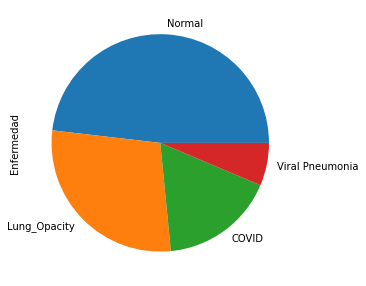

In [6]:
plot = df['Enfermedad'].value_counts().plot.pie(y='Enfermedad', figsize=(5, 5))

Asimismo, obtenemos el número total de imágenes del dataset:

In [7]:
print('Total de imágenes en el dataset:', sum(df['Enfermedad'].value_counts()))

Total de imágenes en el dataset: 21165


Como esperábamos, el conjunto de datos no está balanceado. Debemos tener esto en cuenta posteriormente cuando hayamos partido los datos en entrenamiento y test y debamos tomar decisiones sobre cómo balancearlo, para construir el mejor modelo posible.

Ahora, procedemos a partir el conjunto de datos en train y test. Usualmente, usamos una división 80%$-$20% para entrenamiento y test, respectivamente. No obstante, debido a que tenemos en total 21.165 imágenes (i.e. son bastantes) podemos tomar una partición 90%$-$10%. Así, tendríamos 19.048 en train y 2117 imágenes en test. Lo anterior, con el fin de tener una mayor cantidad de imágenes para entrenar nuestro modelo: por lo general es preferible tener muchos datos. De hecho, según lo visto en clase, una de las mejores formas de evitar/disminuir el <i>overfitting</i> es aumentando la cantidad de datos en el conjunto de entrenamiento. Afortunadamente, en este dataset podemos darnos ese lujo). Posteriormente, guardamos el test en la caja fuerte.

In [8]:
train_df, test_df =train_test_split(df,test_size=0.1, shuffle=True, random_state=28)
X_train, Y_train = train_df['Ruta imagen'], train_df['Enfermedad']

Veamos algunas de las imágenes de nuestro conjunto de datos antes de proceder con el preprocesamiento:

(299, 299, 3)


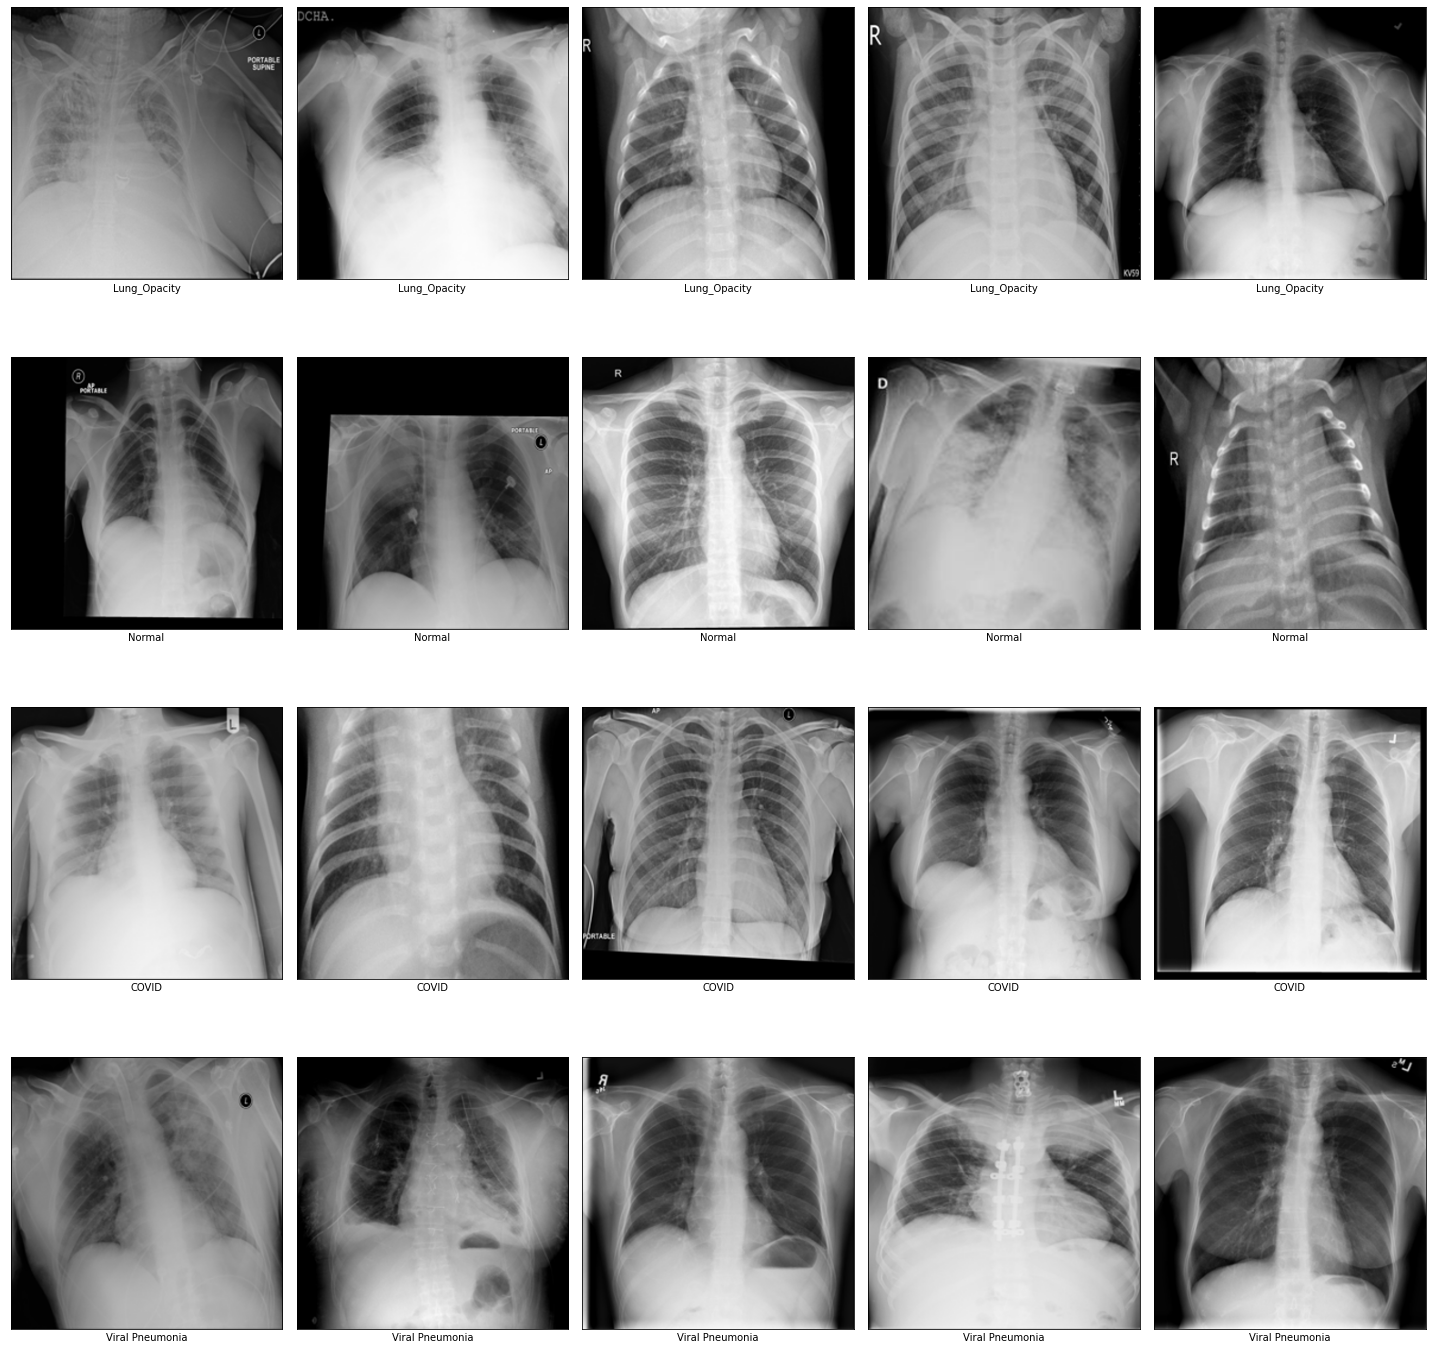

In [9]:
fig, axs = plt.subplots(len(list(Y_train.unique())), 5, figsize = (20, 20))

class_len = {}

for i, c in enumerate(list(Y_train.unique())):
    sample_images = random.sample(list(X_train), 5)
    
    for j, image in enumerate(sample_images):
        img = cv2.imread(image)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])
print(img.shape)

fig.tight_layout()

Aquí podemos ver 5 imágenes correspondientes a cada una de las categorías que tenemos en nuestro dataset. Las imágenes están en tonos grisáceos. No obstante, debemos convertirlas a la escala de grises que el enunciado recomienda, es decir, para que queden en un sólo canal. Note que el tamaño de las imágenes es (299,299,3). El 3 del final significa que aún está en RGB.


Procedemos entonces a realizar el preprocesamiento de las imágenes sugerido por el enunciado.



## Preprocesamiento
Hay dos puntos fundamentales que debemos considerar en el preprocesamiento de imágenes. Sabemos que este varía de acuerdo con el tipo de arquitectura de red neuronal a utilizar. En este caso, la primera decisión que debemos tomar es aquella relacionada con el balanceo de las clases. Como vimos en la exploración, tenemos **muchas** imágenes correspondientes a las clases normales, y, en comparación con ella, pocas de las de las enfermedades.

Una opción sería reducir el conjunto de datos hasta que todas las clases queden con un número de imágenes igual al tamaño de la clase de menor cantidad de imágenes. No obstante, por lo general la idea es no reducir el conjunto de datos. Lo que sí podemos hacer es considerar pesos. Así, el modelo podrá prestar mayor atención a las clases minoritarias.

Ahora cargamos todas las imágenes. En la parte anterior, únicamente revisamos aspectos relacionados con las labels y visualizamos algunas imágenes aleatorias. Ahora sí las cargamos, respetando la partición 90%$-$10% entre train y test, respectivamente, como habíamos definido previamente, pues únicamente tenemos train_df en este punto.

Asimismo, usamos las imágenes en escala de grises, según nos sugiere hacer el enunciado, por medio del parámetro <code>color_mode='grayscale'</code>. Este pedazo es fundamental, pues determina cuántos canales (en este caso, 1) tendrá la imagen. Asimismo, utilizamos <code>class_mode='categorical'</code> que lo que hace es darnos OneHot-Encoding para nuestro modelo.

Cabe aclarar que, en el objeto <code>ImageDataGenerator</code> de Keras, podemos incluir algunos métodos para realizar <code>ImageAugmentation</code>. No obstante, como por la urgencia de la emergencia se nos pide únicamente usar escala de grises y aplanar las imágenes, nos ceñimos únicamente a eso. Cabe aclarar que algo que sí hacemos es reescalar las imágenes por un factor de 1./255. Esto se hace pues todas las imágenes comparten el mismo modelo, pesos y tasa de aprendizaje. De hecho, escalar todas las imágenes al mismo rango [0,1], al multiplicar por 1./255, hará que las imágenes contribuyan más uniformemente a la pérdida total [2].

In [10]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
) 

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='Ruta imagen', 
    y_col='Enfermedad',
    class_mode='categorical',
    color_mode='grayscale',
    classes = list(train_df['Enfermedad'].unique()),
    batch_size = 500, # Un lote tan grande como se pueda, pero que no nos deje sin memoria
    target_size = (299,299), # Este es el tamaño de las imagenes del data set, como vimos mas arriba
    seed=28,
    shuffle = True,
    subset = 'training'
)

Found 19048 validated image filenames belonging to 4 classes.


Podemos ver que las clases son consistentes con lo que habíamos visto en exploración

In [11]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

Ahora, implementamos los pesos, usando la librería apropiada de <code>scikit-learn</code>:

In [12]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(train_generator.classes), 
                y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

Podemos ver los pesos asociados a las clases 0, 1, 2 y 3 respectivamente:

In [13]:
class_weights

array([1.4593932 , 0.87892211, 0.51964208, 3.95843724])

Como era de esperarse, la clase que tiene más peso es la minoritaria: i.e. la correspondiente a pneumonía viral, seguida por COVID. Note que esto coincide con los porcentajes de datos que obtuvimos al comienzo, de acuerdo con la *pie chart* que hicimos.

Con esto, ya estamos casi listos. Únicamente nos faltaría aplanar las imágenes. No obstante, para ello podemos usar la capa <code>Flatten</code> de Keras, la cual aplana la entrada (en este caso, la imagen, como queremos). Esto lo haremos en el siguiente paso: modelamiento.

No obstante, antes de ello, veamos un ejemplo de cómo quedó una imágenes y revisemos su tamaño. Por defecto, <code>Tensorflow</code> ajusta el tamaño a 256$\times$256. Podemos ver que queda un solo canal (correspondiente al último índice del tamaño de la imagen) Asimismo, vemos que el primer índice corresponde al tamaño del batch utilizado.

(500, 299, 299, 1)


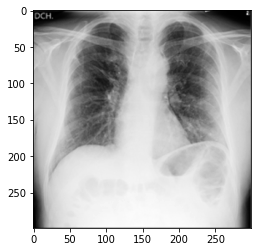

In [14]:
for _ in range(1):
    img, label = train_generator.next()
    print(img.shape)   
    plt.imshow(img[0],cmap='gray')
    plt.show()

La tupla (500, 256, 256, 1) quiere decir que, para cada batch de tamaño 500, cada imagen será de dimensiones (299,299,1). Conservamos las dimensiones de la imagen original, pero redujimos de 3 canales a 1.

## Modelamiento
Sabemos que hay muchas arquitecturas de redes neuronales. En particular, para imágenes, suelen usarse las redes neuronales convolucionales. Estas no las hemos visto a cabalidad en clase. De hecho, la arquitectura de solución que sugiere el enunciado pide "aplanar" la imagen, paso que no es necesario para las CNN. 

Por esta razón, preferimos realizar la ANN correspondiente a un MLP. Es decir, un Multilayer Perceptron. Empezamos por crear el modelo, luego ajustamos sus hiperparámetros. Note que algunas de las cosas que hicimos en preprocesamiento pueden ser hiperparámetros (por ejemplo, el tamaño del batch). No obstante, no los tenemos en cuenta pues el enfoque de las clases aún no ha estado orientado a realizar preprocesamiento en imágenes.

---
Consideremos primero un modelo con una sola capa oculta, de 512 neuronas. Después, haciendo ajuste de hiperparámetros, escogeremos uno mejor.
Para las Redes Neuronales, siempre es importante especificar la dimensión de entrada y la dimensión de la salida esperada:

In [15]:
output = 4 # Pues tenemos 4 clases de clasificación


# Inicializamos el modelo
model_mlp = Sequential()
# Agregamos la capa de Flattening 
model_mlp.add(Flatten(input_shape=(299,299,1))) # Tomamos este input shape porque es el tamanio de nuestras imagenes
# Agregamos la primera capa, con su funcion de activacion respectiva
model_mlp.add(Dense(512, activation='relu'))
# Definimos la tasa de dropout
model_mlp.add(Dropout(0.5))
# Definimos la capa de salida
model_mlp.add(Dense(output, activation='softmax'))

Antes de ver nuestro modelo totalmente construido, conviene discutir un poco lo que acabamos de hacer.
Inicializamos el modelo creando un modelo secuencial. Posteriormente, agregamos una capa de aplanamiento con el fin de convertir las imágenes en arreglos unidimensionales, que son las entradas que reciben los MLP. Más adelante, ponemos nuestra primera (y única) capa oculta. Aquí, justificamos algunas de nuestras decisiones:
* **¿Por qué ReLu?** De acuerdo con la literatura, la función ReLu es la más utilizada en aplicaciones de Machine Learning. En la práctica, además, tiende a tener mejor convergencia que la sigmoide o la tanh [3]. Asimismo, la función de activación ReLu es la que corre en el menor tiempo de cómputo (es menos costoso calcular $\max(0,a)$, donde a es la entrada de la neurona, que calcular, por ejemplo $(1+e^{-a})^{-1}$, para la logística). Por último, en varias aplicaciones y artículos, se ha visto que ReLu se desempeña muy bien en casi todos los casos. Y si hay otras mejores, en realidad la mejoría es muy baja [4]. Por lo tanto, por lo general (y sobre todo para problemas complejos como este), no vale la pena buscar una función de activación diferente. 
* **¿Por qué 512 neuronas?** Realmente, esta es una decisión un poco arbitraria. Una forma naïve de calcular el número de neuronas de la capa oculta es que sea menos del doble de las de la capa de entrada [5]. No obstante, esas serían muchísimas neuronas en nuestro caso (pues la entrada es la imagen aplanada). Por lo tanto, seguramente habría overfitting y el costo computacional es inmenso. Tomamos 512 neuronas pues no son muy pocas, tal que haga underfitting, pero tampoco muchas. No obstante, este es un hiperparámetro que debemos ajustar más adelante.
Para nuestro primer modelo naïve, utilizamos una única capa oculta. Esto es porque estamos intentando crear un modelo simple. No obstante, este será uno de los hiperparámetros que ajustaremos. 

Más adelante, añadimos una capa de Dropout. Esta es una capa de regularización, que hace que se aprenda una fracción de los pesos en la red. Para redes grandes, se recomienda $p=0.5$, la cual corresponde a la máxima regularización. Esto también lo ajustaremos como hiperparámetro, pero es un buen punto de partida para nuestro primer modelo [6].

Finalmente, tenemos la capa de salida: compuesta por 4 neuronas (pues tenemos 4 clases), con función de activación <code>softmax</code>. Esta se usa con frecuencia en clasificación multiclase, por lo que es una decisión completamente adecuada para la salida de nuestra red. Ahora sí, veamos cómo vamos:

In [16]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 89401)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               45773824  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 45,775,876
Trainable params: 45,775,876
Non-trainable params: 0
_________________________________________________________________


Ahora, debemos elegir una métrica, una función de pérdida y un optimizador. En cuanto a la función de pérdida, la que se usa con frecuencia en problemas de clasificación es la de entropía cruzada. De hecho, se recomienda no cambiarla, a menos de que se tenga una razón lo suficientemente fuerte para hacerlo, pues es la función de pérdida preferida en el marco de la máxima verosimilitud. Para problemas multiclase, donde se tiene OneHotEncoding, se utiliza entropía cruzada categórica: <code>categorical_crossentropy</code> [7].

En el caso del optimizador, elegimos adam. Por lo general, este es el que mejores resultados presenta, de acuerdo con la literatura. Asimismo, nos quitamos de encima el ajustar un hiperparámetro extra (la tasa de aprendizaje), pues los algoritmos adaptativos como Adam van ajustando esta tasa a medida que entrenan [8]. Últimamente se ha visto que SGD, acompañado de un buen learning rate, puede arrojar resultados excelentes también. No obstante, esto implica el ajuste de un hiperparámetro que, dada la complejidad del problema, puede ser muy costosa computacionalmente.

Otro de los hiperparámetros que necesitamos tener en cuenta para nuestro entrenamiento es la métrica que informa el éxito del modelo. En este caso elegimos la exactitud (accuracy) como métrica, pues el usuario aspira poder diagnosticar de forma amplia sobre las cuatro categorías, no sólo sobre COVID-19. En consecuencia, tiene más sentido utilizar una métrica que reporte el éxito general del modelo sin privilegiar una categoría sobre otra, máxime si se considera el desbalanceo en el tamaño de nuestras clases.

In [17]:
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy'])

#### Control de la complejidad y los tiempos de procesamiento
Una forma de controlar la complejidad y los tiempos de procesamiento es mediante el uso de callbacks. Estas son acciones durante las etapas del entrenamiento.

De acuerdo con la documentación de Tensorflow, encontramos dos callbacks que consideramos útiles para este laboratorio. Primero, consideramos <code>EarlyStopping</code>. En este caso, ponemos la cantidad monitoreada como la medida que tomamos como métrica. Es decir, si la métrica es accuracy (exactitud), pararíamos el entrenamiento si no hay mejora después de paciencia=5 épocas. 

El otro callback que utilizaremos es <code>TensorBoard</code>. Este permite visualizar un reporte del entrenamiento, el cual nos será útil para concluir sobre el entrenamiento del modelo.

Por último, vimos un callback que se usa para cambiar el <code>learning rate</code> de acuerdo con el monitor seleccionado. Es decir, si la métrica deja de mejorar, se reduce la tasa de aprendizaje. Elegimos el valor por defecto, de 0.1

In [18]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
#reduce_LR_on_plateau = ReduceLROnPlateau(monitor='Accuracy',  factor=0.1, patience=5, verbose=1, mode='auto')

callbacks = [early_stopping,tensorboard_callback]



In [ ]:
history = model_mlp.fit(train_generator, epochs= 20, callbacks=callbacks, class_weight=train_class_weights)

Epoch 1/20
39/39 [==============================] - 52s 1s/step - loss: 28.1111 - Accuracy: 0.3701


## Validación

Para el conjunto de validación, ponemos las imágenes del mismo tamaño que en el train (i.e. las reescalamos) y ya. No podemos hacer data augmentation con ellas. Asimismo, usamos la misma semilla, con el fin de obtener imágenes diferentes a las que el modelo ya vio en train.

In [ ]:
datagen_test = ImageDataGenerator(
    rescale = 1./255
) 

test_generator = datagen_test.flow_from_dataframe(
    test_df,
    x_col='Ruta imagen', 
    y_col='Enfermedad',
    color_mode='grayscale',
    classes = list(test_df['Enfermedad'].unique()),
    seed = 8,
    batch_size = 32, 
    shuffle = True
)

De hecho, podemos revisar que, en efecto, no hay imágenes repetidas:

In [ ]:
# Para que no se repitan imágenes entre train y test, nos cercioramos de que el resultado sea el conjunto vacío.
set(test_generator.filenames).intersection(set(train_generator.filenames))

## Referencias
[1] Coronavirus disease (COVID-19) – World Health Organization. (2021). Retrieved 5 October 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019?gclid=Cj0KCQjwwY-LBhD6ARIsACvT72PqduqyNWdB9YQ3awfqyC9FZ1y5Zy7srhp8wrVgEPPmzW4Jgll_Di8aAiDuEALw_wcB

[2] https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/

[3] http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf

[4] https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks

[5] Kurt Hornik (1991) “Approximation Capabilities of Multilayer Feedforward Networks”, Neural Networks, 4(2), 251–257. doi:10.1016/0893-6080(91)90009-T

[6] https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

[7] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

[8] https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

[9] 